In [46]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.special as sp
from math import *
from golden import golden
from bisection import bisection
from secant import secant
from ivp_two import rk4_gen
from ivp_one import rk4

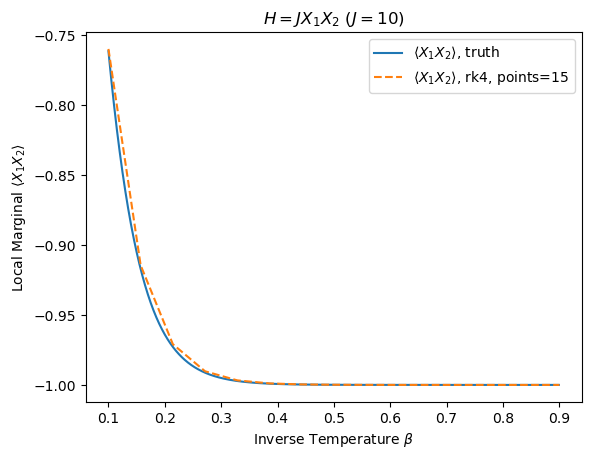

In [218]:
J=10
def f(beta, y0):
    return (-J + J*y0**2)

def freal(beta):
    return (-np.tanh(beta*J))

n=15; a=0.1; b=0.9
yinit = -0.76           #initial condition from analytical solution -tanh(beta.J) at beta=0.1
xs, ys = rk4(f,a,b,n,yinit)

xs_fine = np.arange(a, b, 0.001)
yreal = [freal(beta) for beta in xs_fine]

plt.plot(xs_fine, yreal, label=r'$\langle X_1X_2\rangle$, truth')
plt.plot(xs, ys, '--',label=r'$\langle X_1X_2\rangle$, rk4, points=%s'%n)
plt.legend()
plt.xlabel(r'Inverse Temperature $\beta$')
plt.ylabel(r'Local Marginal $\langle X_1 X_2\rangle$')
plt.title(r'$H=JX_1X_2$ ($J=%s$)'%J)
plt.show()

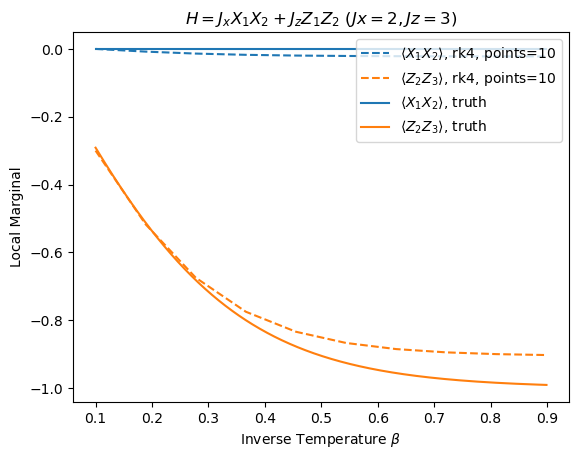

In [215]:
#interaction terms
XX = np.array([ [0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0] ])
ZZ = np.array([ [1,0,0,0],[0,-1,0,0],[0,0,1,0],[0,0,0,-1] ])
Id = np.array([ [1,0],[0,1] ])
X1X2 = np.kron(XX,Id)
Z2Z3 = np.kron(Id,ZZ)

#hamiltonian
def Ham(Jx, Jz):
    mat = Jx*X1X2 + Jz*Z2Z3
    return mat

#marginals
def margX1X2(beta, H):
    expo = np.exp(-beta*H)
    val1 = np.trace(X1X2*expo)
    val2 = np.trace(expo)
    return val1/val2
def margZ2Z3(beta, H):
    expo = np.exp(-beta*H)
    val1 = np.trace(Z2Z3*expo)
    val2 = np.trace(expo)
    return val1/val2
def margH(beta, H):
    expo = np.exp(-beta*H)
    val1 = np.trace(H*expo)
    val2 = np.trace(expo)
    return val1/val2
def margX1X2H(beta, H):
    expo = np.exp(-beta*H)
    val1 = np.trace(X1X2*H*expo)
    val2 = np.trace(expo)
    return val1/val2
def margZ2Z3H(beta, H):
    expo = np.exp(-beta*H)
    val1 = np.trace(Z2Z3*H*expo)
    val2 = np.trace(expo)
    return val1/val2

brange = np.arange(0.1,0.9,0.001)
Jx=2; Jz=3
H = Ham(Jx, Jz)
margX1X2_list = [ margX1X2(beta,H) for beta in brange ]
margZ2Z3_list = [ margZ2Z3(beta,H) for beta in brange ]
margH_list = [ margH(beta,H) for beta in brange ]
margX1X2H_list = [ margX1X2H(beta,H) for beta in brange ]
margZ2Z3H_list = [ margZ2Z3H(beta,H) for beta in brange ]

def fs(xs, yvals):
    y0, y1, y2, y3, y4 = yvals
    f0 = -y3 + y2*y0
    f1 = -y4 + y2*y1
    f2 = y2**2 - (Jx**2 + Jz**2)
    f3 = y2*y3 - (Jx**2 + Jz**2)*y0
    f4 = y2*y4 - (Jx**2 + Jz**2)*y1
    return np.array([f0, f1, f2, f3, f4])

n=10                                         #points for RK4
a=brange[0]; b=brange[-1]
yinits = np.array([0.0, -0.3, -0.9, 0.1, 3.0])  #Initial Values of <X1X2>,<Z2Z3>,<H>,<X1X2H>,<Z2Z3H> respectively

xs, ys_rk4 = rk4_gen(fs, a, b, n, yinits)
plt.plot(xs, ys_rk4[:,0],'--', label=r'$\langle X_1X_2\rangle$, rk4, points=%s'%n)
plt.plot(xs, ys_rk4[:,1],'--', label=r'$\langle Z_2Z_3\rangle$, rk4, points=%s'%n)

plt.gca().set_prop_cycle(None)
plt.plot(brange, margX1X2_list, label=r'$\langle X_1X_2\rangle$, truth')
plt.plot(brange, margZ2Z3_list, label=r'$\langle Z_2Z_3\rangle$, truth')

plt.xlabel(r'Inverse Temperature $\beta$')
plt.ylabel(r'Local Marginal')
plt.title(r'$H=J_xX_1X_2 + J_zZ_1Z_2$ ($Jx=%s, Jz=%s$)'%(Jx,Jz))
plt.legend(loc='upper right')

plt.show()

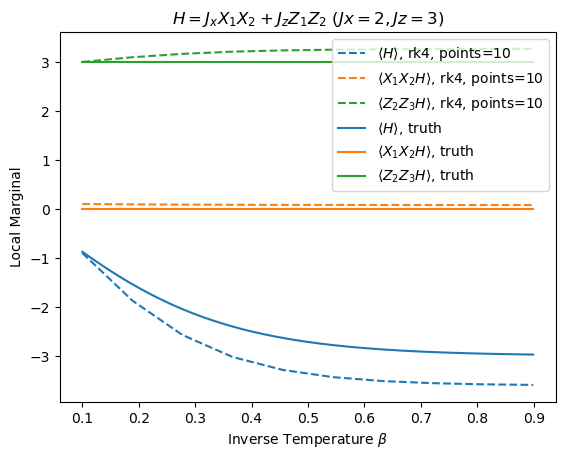

In [217]:
plt.plot(xs, ys_rk4[:,2],'--', label=r'$\langle H\rangle$, rk4, points=%s'%n)
plt.plot(xs, ys_rk4[:,3],'--', label=r'$\langle X_1X_2H\rangle$, rk4, points=%s'%n)
plt.plot(xs, ys_rk4[:,4],'--', label=r'$\langle Z_2Z_3H\rangle$, rk4, points=%s'%n)
plt.gca().set_prop_cycle(None)
plt.plot(brange, margH_list, label=r'$\langle H\rangle$, truth')
plt.plot(brange, margX1X2H_list, label=r'$\langle X_1X_2H\rangle$, truth')
plt.plot(brange, margZ2Z3H_list, label=r'$\langle Z_2Z_3H\rangle$, truth')

plt.xlabel(r'Inverse Temperature $\beta$')
plt.ylabel(r'Local Marginal')
plt.title(r'$H=J_xX_1X_2 + J_zZ_1Z_2$ ($Jx=%s, Jz=%s$)'%(Jx,Jz))
plt.legend(loc='upper right')
plt.show()

RK4 implementations used in this work (due to Alex Gezerlis) :

In [ ]:
def rk4(f,a,b,n,yinit):
    h = (b-a)/(n-1)
    xs = a + np.arange(n)*h
    ys = np.zeros(n)

    y = yinit
    for j,x in enumerate(xs):
        ys[j] = y
        k0 = h*f(x, y)
        k1 = h*f(x+h/2, y+k0/2)
        k2 = h*f(x+h/2, y+k1/2)
        k3 = h*f(x+h, y+k2)
        y += (k0 + 2*k1 + 2*k2 + k3)/6
    return xs, ys

def rk4_gen(fs,a,b,n,yinits):
    h = (b-a)/(n-1)
    xs = a + np.arange(n)*h
    ys = np.zeros((n, yinits.size))

    yvals = np.copy(yinits)
    for j,x in enumerate(xs):
        ys[j,:] = yvals
        k0 = h*fs(x, yvals)
        k1 = h*fs(x+h/2, yvals+k0/2)
        k2 = h*fs(x+h/2, yvals+k1/2)
        k3 = h*fs(x+h, yvals+k2)
        yvals += (k0 + 2*k1 + 2*k2 + k3)/6
    return xs, ys